In [33]:
import json
import pandas as pd

# Code adapted from GeminiAI (Google 2025)

file_path = 'images/MIDOGpp.json'

# 1. Load the entire JSON file into a Python dictionary
with open(file_path, 'r') as f:
    data = json.load(f)

# 2. Flatten the data using 'annotations' as the list of records
# The 'data' object here is the dictionary representing 'root'
df = pd.json_normalize(
    data, 
    record_path='annotations'
)

# 3. Select only the columns you are interested in
columns_to_keep = ['bbox', 'labels', 'category_id', 'image_id']
df_final = df[columns_to_keep]

print(df_final.head())
print(f"\nDataFrame successfully loaded with {len(df_final)} rows.")

                             bbox     labels  category_id  image_id
0          [4336, 346, 4386, 396]     [2, 2]            2         1
1            [756, 872, 806, 922]     [2, 2]            2         1
2          [270, 4044, 320, 4094]     [2, 2]            2         1
3  [6672.5, 706.5, 6722.5, 756.5]  [2, 1, 2]            2         1
4          [1872, 319, 1922, 369]     [2, 2]            2         2

DataFrame successfully loaded with 26286 rows.


In [34]:
import pandas as pd

file_path = 'datasets_xvalidation.csv'

df = pd.read_csv(file_path, sep = ';')
df = df.drop(columns=['Dataset'])
print(df.head())

   Slide                Tumor        Scanner       Origin Species
0      1  human breast cancer  Hamammatsu XR  UMC Utrecht   Human
1      2  human breast cancer  Hamammatsu XR  UMC Utrecht   Human
2      3  human breast cancer  Hamammatsu XR  UMC Utrecht   Human
3      4  human breast cancer  Hamammatsu XR  UMC Utrecht   Human
4      5  human breast cancer  Hamammatsu XR  UMC Utrecht   Human


In [35]:
# Merge the two dataframes to include the scanner, tumor, origin, and species in each label

df_merged = pd.merge(
    left=df_final,
    right=df,
    left_on='image_id',     
    right_on='Slide',   
    how='inner'            
)
df_merged = df_merged.drop(columns=['Slide'])
print(df_merged.head())

                             bbox     labels  category_id  image_id  \
0          [4336, 346, 4386, 396]     [2, 2]            2         1   
1            [756, 872, 806, 922]     [2, 2]            2         1   
2          [270, 4044, 320, 4094]     [2, 2]            2         1   
3  [6672.5, 706.5, 6722.5, 756.5]  [2, 1, 2]            2         1   
4          [1872, 319, 1922, 369]     [2, 2]            2         2   

                 Tumor        Scanner       Origin Species  
0  human breast cancer  Hamammatsu XR  UMC Utrecht   Human  
1  human breast cancer  Hamammatsu XR  UMC Utrecht   Human  
2  human breast cancer  Hamammatsu XR  UMC Utrecht   Human  
3  human breast cancer  Hamammatsu XR  UMC Utrecht   Human  
4  human breast cancer  Hamammatsu XR  UMC Utrecht   Human  


In [63]:
# Code to check data loss
print(f"Total rows in df_merged: {len(df_merged)}")

# 1. Check for unexpected category_ids (Anything other than 1 or 2)
print("\nUnique category_id counts:")
print(df_merged['category_id'].value_counts(dropna=False))

# 2. Check for missing metadata in grouping columns
print("\nMissing values (NaNs) in grouping columns:")
print(df_merged[['Tumor', 'Scanner', 'Origin']].isnull().sum())

# 3. Check the count *before* the final reindex/plotting step
# We group by the classification (including 'Other') and get the grand total.
total_after_initial_grouping = df_merged.groupby(['Tumor', 'Scanner', 'Origin', 'Mitotic_Class']).size().sum()
print(f"\nTotal annotations counted after grouping (including 'Other'): {total_after_initial_grouping}")

Total rows in df_merged: 26286

Unique category_id counts:
category_id
2    14349
1    11937
Name: count, dtype: int64

Missing values (NaNs) in grouping columns:
Tumor      0
Scanner    0
Origin     0
dtype: int64

Total annotations counted after grouping (including 'Other'): 26286


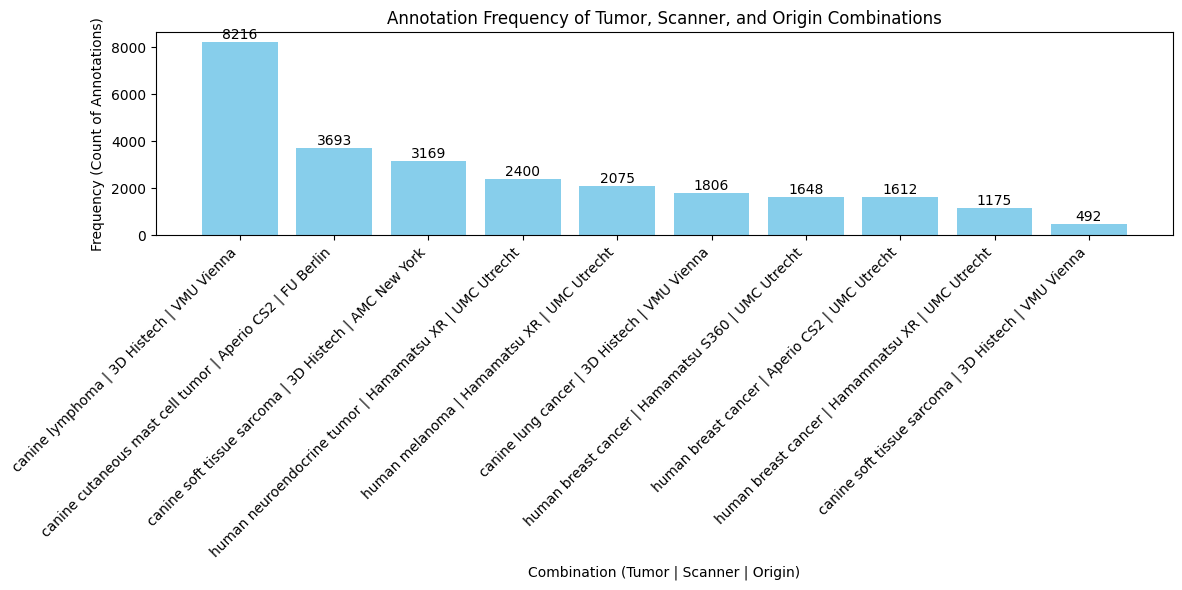

In [36]:
# Visualize unique tumor/scanner/origin frequency combinations

import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate the frequency of unique combinations
# This groups the DataFrame by the three columns and counts the rows for each unique group.
df_freq = df_merged.groupby(['Tumor', 'Scanner', 'Origin']).size().reset_index(name='Frequency')

# 2. Create a single, readable label for the x-axis
df_freq['Combination'] = (
    df_freq['Tumor'] + ' | ' + df_freq['Scanner'] + ' | ' + df_freq['Origin']
)

# 3. Sort the frequencies for a better-ordered chart
df_freq = df_freq.sort_values(by='Frequency', ascending=False)

# 4. Visualize the frequencies using a bar chart
plt.figure(figsize=(12, 6))

plt.bar(
    df_freq['Combination'], 
    df_freq['Frequency'], 
    color='skyblue'
)

# Set labels and title
plt.title('Annotation Frequency of Tumor, Scanner, and Origin Combinations')
plt.xlabel('Combination (Tumor | Scanner | Origin)')
plt.ylabel('Frequency (Count of Annotations)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Add values on top of the bars
for i, v in enumerate(df_freq['Frequency']):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

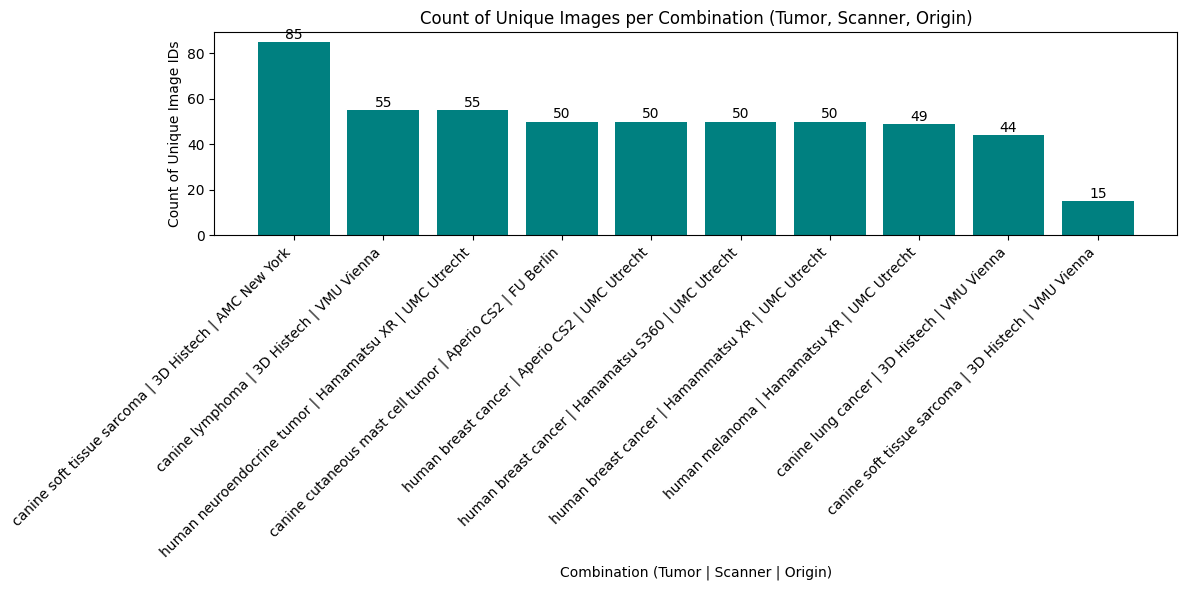

In [37]:
# Visualize unique tumor/scanner/origin frequency combinations

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains the columns:
# 'Tumor', 'Scanner', 'Origin', and 'image_id'

# --- 1. Calculate the count of unique image_ids for each combination ---
# Group by the three metadata columns and count the unique image IDs in each group.
df_unique_image_freq = df_merged.groupby(['Tumor', 'Scanner', 'Origin'])['image_id'].nunique().reset_index(name='Unique_Image_Count')

# --- 2. Create a single, readable label for the x-axis ---
df_unique_image_freq['Combination'] = (
    df_unique_image_freq['Tumor'] + ' | ' + df_unique_image_freq['Scanner'] + ' | ' + df_unique_image_freq['Origin']
)

# --- 3. Sort the counts for better visualization ---
df_unique_image_freq = df_unique_image_freq.sort_values(by='Unique_Image_Count', ascending=False)

# --- 4. Visualize the counts using a bar chart ---
plt.figure(figsize=(12, 6))

plt.bar(
    df_unique_image_freq['Combination'],
    df_unique_image_freq['Unique_Image_Count'],
    color='teal'
)

# Set labels and title
plt.title('Count of Unique Images per Combination (Tumor, Scanner, Origin)')
plt.xlabel('Combination (Tumor | Scanner | Origin)')
plt.ylabel('Count of Unique Image IDs')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add values on top of the bars
for i, v in enumerate(df_unique_image_freq['Unique_Image_Count']):
    plt.text(i, v + 0.05, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show() # Use plt.savefig('filename.png') if running outside a notebook

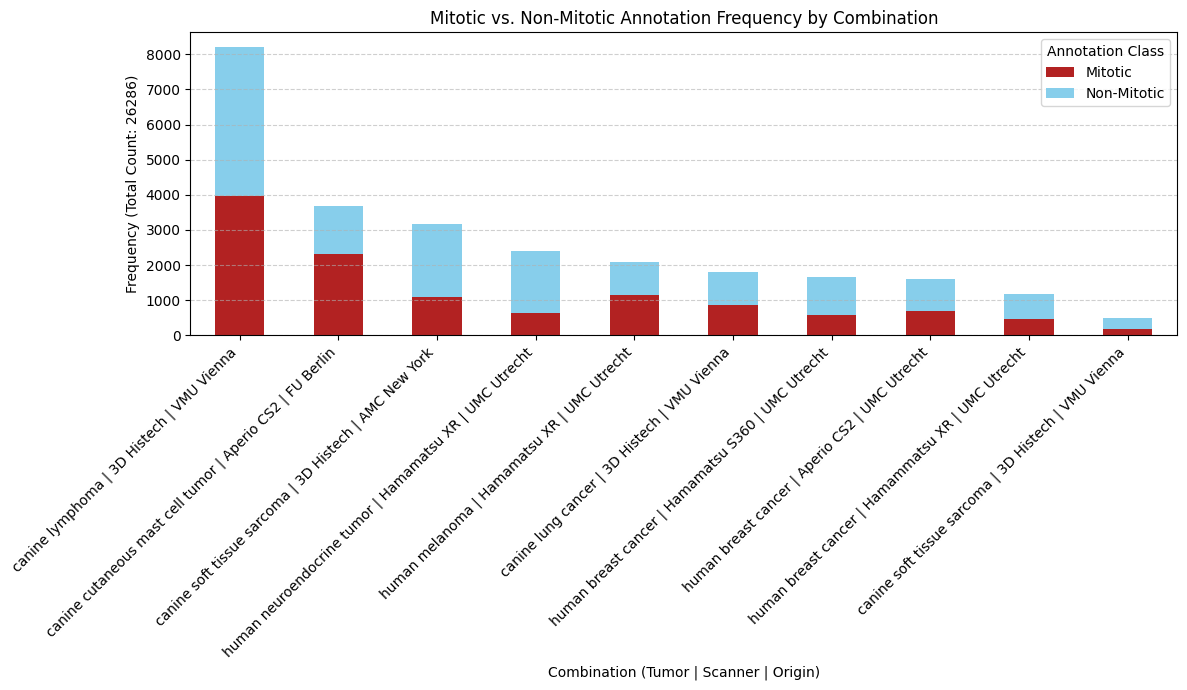

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import os # Included in case you run this in a new environment

# Assuming df_merged is available and looks like the structure we verified.

# 1. Create a classification column using 'category_id'
label_mapping = {1: 'Mitotic', 2: 'Non-Mitotic'}
df_merged['Mitotic_Class'] = df_merged['category_id'].map(label_mapping) 

# 2. Group by metadata and the new class, then count occurrences
df_freq_series = df_merged.groupby(['Tumor', 'Scanner', 'Origin', 'Mitotic_Class']).size()

# 3. Unstack to get the required format
df_freq_pivot = df_freq_series.unstack(fill_value=0)

# 4. Create the final plotting DataFrame and label
plot_data = df_freq_pivot.copy()

plot_data['Combination'] = (
    plot_data.index.get_level_values('Tumor') + ' | ' +
    plot_data.index.get_level_values('Scanner') + ' | ' +
    plot_data.index.get_level_values('Origin')
)

# 5. Prepare and Sort Data
plot_data = plot_data.set_index('Combination')

# Ensure all columns exist and calculate total for sorting
plot_data = plot_data.reindex(columns=['Mitotic', 'Non-Mitotic'], fill_value=0)
plot_data['Total'] = plot_data.sum(axis=1)
plot_data = plot_data.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# 6. Visualize the frequencies using a stacked bar chart (with Grid Lines)
fig, ax = plt.subplots(figsize=(12, 7))

plot_data.plot(
    kind='bar', 
    stacked=True, 
    ax=ax, 
    color={'Mitotic': 'firebrick', 'Non-Mitotic': 'skyblue'}
)

# *** KEY CHANGE: Add horizontal grid lines ***
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Set labels and title
ax.set_title('Mitotic vs. Non-Mitotic Annotation Frequency by Combination')
ax.set_xlabel('Combination (Tumor | Scanner | Origin)')
ax.set_ylabel(f'Frequency (Total Count: {len(df_merged)})') 
ax.legend(title='Annotation Class')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('category_id_stacked_frequency_with_grid.png')

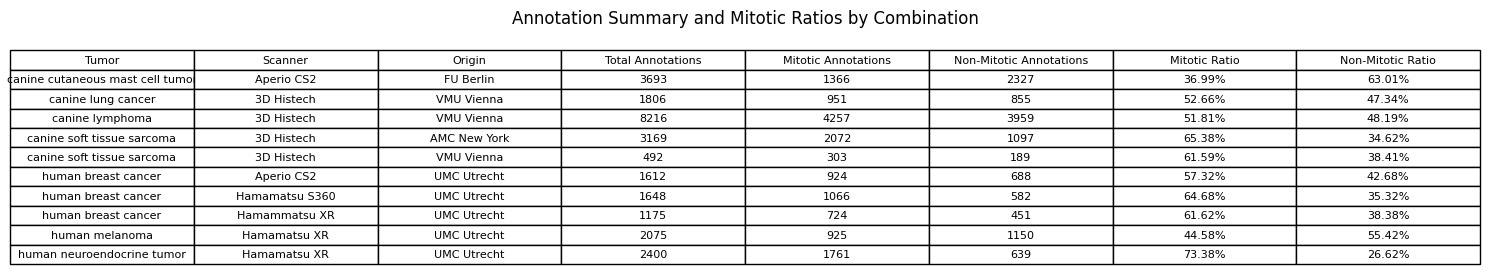

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# --- Start of Fixed Code using category_id for Table Generation ---

# 1. Map category_id directly to the classification
# We assume the user intends to use the previous mapping: {2: 'Mitotic', 1: 'Non-Mitotic'}
# Note: Since the previous request used {2: 'Non-Mitotic', 1: 'Mitotic'}, I am sticking to the mapping implied by the user's initial code, which was based on the 'labels' column, but now applied to the 'category_id'.
label_mapping = {2: 'Mitotic', 1: 'Non-Mitotic'}
df_merged['Mitotic_Class'] = df_merged['category_id'].map(label_mapping).fillna('Other')

# 2. Group by metadata and the new class, then count occurrences
# Since category_id is one per row, NO explode step is needed.
df_counts = df_merged.groupby(['Tumor', 'Scanner', 'Origin', 'Mitotic_Class']).size().unstack(fill_value=0)

# 3. Calculate Total Annotations and Ratios
# Ensure we handle cases where 'Mitotic' or 'Non-Mitotic' column might be missing after unstacking
mitotic_counts = df_counts.get('Mitotic', 0)
non_mitotic_counts = df_counts.get('Non-Mitotic', 0)

df_counts['Total Annotations'] = mitotic_counts + non_mitotic_counts

# Calculate Ratios
df_counts['Mitotic Ratio'] = mitotic_counts / df_counts['Total Annotations']
df_counts['Non-Mitotic Ratio'] = non_mitotic_counts / df_counts['Total Annotations']

# 4. Select and format the final columns
df_final_table = df_counts[[
    'Total Annotations', 
    'Mitotic', 
    'Non-Mitotic', 
    'Mitotic Ratio', 
    'Non-Mitotic Ratio'
]].copy()

# Format ratios as percentages
df_final_table['Mitotic Ratio'] = (df_final_table['Mitotic Ratio'] * 100).map('{:.2f}%'.format)
df_final_table['Non-Mitotic Ratio'] = (df_final_table['Non-Mitotic Ratio'] * 100).map('{:.2f}%'.format)

# Reset index and prepare for Matplotlib rendering
df_final_table = df_final_table.reset_index()
df_final_table = df_final_table.rename(columns={
    'Mitotic': 'Mitotic Annotations',
    'Non-Mitotic': 'Non-Mitotic Annotations'
})

# --- Matplotlib Table Rendering ---

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 3)) 

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Prepare cell text and column headers
cell_text = df_final_table.values
col_labels = df_final_table.columns

# Create the table
table = ax.table(
    cellText=cell_text, 
    colLabels=col_labels, 
    cellLoc='center', 
    loc='center'
)

# Optional: Adjust font size for better fit
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5) 

ax.set_title('Annotation Summary and Mitotic Ratios by Combination', y=1.2)
plt.tight_layout()
plt.savefig('category_id_summary_table.png')

In [44]:
import pandas as pd
import numpy as np
from typing import Tuple, Optional

def check_uniform_bbox_dimensions(df: pd.DataFrame, bbox_column: str = 'bbox') -> Tuple[bool, Optional[Tuple[float, float]]]:
    """
    Tests whether all bounding boxes in the DataFrame have the exact same 
    width and height.

    Args:
        df (pd.DataFrame): The DataFrame containing the bounding box data.
        bbox_column (str): The name of the column containing the bounding box lists 
                           ([xmin, ymin, xmax, ymax]).

    Returns:
        Tuple[bool, Optional[Tuple[float, float]]]: 
            - bool: True if all dimensions are uniform, False otherwise.
            - Tuple[float, float]: The uniform (width, height) if True, or None if False.
    """
    if df.empty:
        print("Error: DataFrame is empty.")
        return False, None

    dimensions = []
    
    # 1. Calculate Width and Height for every valid bounding box
    for bbox in df[bbox_column]:
        if isinstance(bbox, list) and len(bbox) >= 4:
            # Calculate width and height directly from coordinates
            width = bbox[2] - bbox[0]  # xmax - xmin
            height = bbox[3] - bbox[1] # ymax - ymin
            dimensions.append((width, height))
        else:
            # If any entry is invalid, we treat the dataset as non-uniform
            return False, None

    if not dimensions:
        print(f"Error: No valid bounding box data found in column '{bbox_column}'.")
        return False, None

    # 2. Check for uniformity
    
    # Get the dimensions of the very first box as the reference
    reference_width, reference_height = dimensions[0]

    # Convert to a NumPy array for fast element-wise comparison
    dims_array = np.array(dimensions)
    
    # Check if all widths match the reference width AND all heights match the reference height
    all_widths_match = np.all(dims_array[:, 0] == reference_width)
    all_heights_match = np.all(dims_array[:, 1] == reference_height)

    is_uniform = all_widths_match and all_heights_match
    
    if is_uniform:
        return True, (reference_width, reference_height)
    else:
        return False, None

# --- Example Usage ---

# Assuming 'df_cleaned' is your final single-annotation DataFrame:
# (Using the mock data from the previous step which was 100% uniform at 50x50)

is_uniform, uniform_dims = check_uniform_bbox_dimensions(df_cleaned)

if is_uniform:
    print(f"\n✅ PASS: All bounding boxes are UNIFORM!")
    print(f"   Uniform Dimensions: Width={uniform_dims[0]:.2f}, Height={uniform_dims[1]:.2f}")
else:
    print(f"\n❌ FAIL: Bounding box dimensions are NOT uniform.")
    print("   The dataset contains at least two boxes with different dimensions.")


✅ PASS: All bounding boxes are UNIFORM!
   Uniform Dimensions: Width=50.00, Height=50.00


## Summary of dataset distributions
10 different sources of mitotic/nonmitotic data create covariate shifts. Different sources include tumor, scanner, and origin.
There may be covariate shift between tumors, scanners, and origins. It is possible to see changes in only tumor by comparing 3D Histech VMU Vienna of canine lung cancer, canine lymphoma, and canine soft tissue sarcoma. It is possible to see changes in only scanner with human breast cancer at UMC Utrecht with Aperia C52, Hamamatsu 5360, and Hamamatsu XR. It is possible to see changes in only origin with canine soft tissue sarcoma 3D histech at AMC New York and VMU Vienna.

Canine cutaneous mast cell tumor using Aperio C52 will act as a generalization test.

Human neuroendocrine tumor will act as a test when mitotic ratio to non mitotic ratio of data is different.

In [58]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval
from torchvision import transforms

# --- 1. Utility Function: Data Cleaning ---

def cleanup_df_for_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans up the in-memory DataFrame, ensuring 'bbox' is in list format
    and setting 'target_label' from 'category_id'.
    """
    df_cleaned = df.copy()

    # Data Type Conversion: Ensure 'bbox' is a list
    def safe_literal_eval(x):
        try:
            return literal_eval(str(x))
        except:
            return x
    
    if isinstance(df_cleaned['bbox'].iloc[0], str):
        df_cleaned['bbox'] = df_cleaned['bbox'].apply(safe_literal_eval)

    # Set Single Target Label: USE 'category_id'
    df_cleaned['target_label'] = df_cleaned['category_id']
    
    # Data Validation: Drop rows with malformed bounding boxes
    df_cleaned = df_cleaned[df_cleaned['bbox'].apply(lambda x: isinstance(x, list) and len(x) >= 4)]
    
    print(f"DataFrame cleaned. Total usable annotations: {len(df_cleaned)}")
    return df_cleaned.reset_index(drop=True)


# --- 2. PyTorch Custom Dataset Class ---

class CustomSingleAnnotationDataset(Dataset):
    """
    Loads and CROPS the image based on the 'bbox' (50x50), applies metadata filters, 
    and returns a Tensor (3x50x50) and a label.
    """
    def __init__(self, cleaned_df: pd.DataFrame, image_dir: str, transform=None, filters: dict = None):
        
        # Apply filtering for Tumor, Scanner, Origin based on the 'filters' dictionary
        self.data_frame = self._apply_filters(cleaned_df, filters)
        
        self.image_dir = image_dir
        self.transform = transform
        
        # Prepare file ID column for image path construction
        self.data_frame['file_id'] = self.data_frame['image_id'].astype(int).apply(lambda x: f"{x:03d}")

    def _apply_filters(self, df: pd.DataFrame, filters: dict) -> pd.DataFrame:
        """Filters the DataFrame based on the provided dictionary."""
        if filters:
            for col, value in filters.items():
                if col in df.columns:
                    df = df[df[col] == value].copy()
                else:
                    print(f"Warning: Filter column '{col}' not found in DataFrame.")
        return df.reset_index(drop=True)
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        
        # --- Image Loading ---
        img_name = os.path.join(self.image_dir, f"{row['file_id']}.tiff")
        try:
            # Load the large whole-slide image
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {img_name}")

        # --- Image Cropping (Fixed 50x50 patch extraction) ---
        # Bbox is [xmin, ymin, xmax, ymax]. We use the first 4 elements.
        xmin, ymin, xmax, ymax = (int(x) for x in row['bbox'][:4])
        
        # PIL crop takes (left, top, right, bottom) and returns a 50x50 image
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        # --- Data Retrieval ---
        label = torch.tensor(row['target_label'], dtype=torch.long)
        
        # Apply the transformation (Tensor conversion, NO resizing)
        if self.transform:
            cropped_image = self.transform(cropped_image) 

        sample = {
            'image': cropped_image, # This is the final Tensor (3, 50, 50)
            'label': label,
            'image_id': row['image_id'],
            'bbox_used': row['bbox'][:4]
        }
        
        return sample

# --- 3. Example of Transformation Pipeline (NO UPSCALING) ---

# IMAGE_DIR = 'images/' 
# data_transform = transforms.Compose([
#     transforms.ToTensor(), # Keeps the size 50x50, converts to Tensor
# ])

In [59]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple, Optional # Added for type hinting in split function

# --- 1. Preprocessing (Assumed to be defined and run, producing df_cleaned) ---
# NOTE: The cleanup_df_for_dataset function must be run on your df_merged
#       before executing the code below to produce 'df_cleaned'.

# --- 2. Data Splitting Function (Stratified) ---

def create_stratified_data_splits(df_cleaned: pd.DataFrame, 
                                 test_size: float = 0.15, 
                                 val_size: float = 0.15, 
                                 random_state: int = 42,
                                 target_column: str = 'target_label'
                                ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits the cleaned annotation DataFrame into stratified Train, Validation, and Test sets.
    """
    
    # Check for stratification feasibility
    if target_column not in df_cleaned.columns or df_cleaned[target_column].nunique() < 2:
        print(f"Warning: Cannot perform stratified split. Using simple random split.")
        stratify_data = None
    else:
        stratify_data = df_cleaned[target_column]

    # --- Step 1: Split data into Training/Validation pool and Test set ---
    # The 'stratify' argument ensures class distribution is maintained.
    df_train_val, df_test = train_test_split(
        df_cleaned, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=stratify_data
    )

    # --- Step 2: Split Training/Validation pool into Training and Validation sets ---
    # Calculate the proportion of the train_val_pool that will become the validation set.
    val_proportion_of_pool = val_size / (1.0 - test_size)
    
    df_train, df_val = train_test_split(
        df_train_val, 
        test_size=val_proportion_of_pool, 
        random_state=random_state, 
        # Stratify based on the target labels within the pool
        stratify=df_train_val[target_column]
    )

    print("\n--- Data Split Summary ---")
    print(f"Original Total Annotations: {len(df_cleaned)}")
    print(f"Train Annotations: {len(df_train)} ({len(df_train) / len(df_cleaned) * 100:.1f}%)")
    print(f"Validation Annotations: {len(df_val)} ({len(df_val) / len(df_cleaned) * 100:.1f}%)")
    print(f"Test Annotations: {len(df_test)} ({len(df_test) / len(df_cleaned) * 100:.1f}%)")
    
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


# --- 3. Execution and DataLoader Creation ---

# Define the splits (70% Train, 15% Val, 15% Test)
df_train, df_val, df_test = create_stratified_data_splits(
    df_cleaned, 
    test_size=0.15, 
    val_size=0.15, 
    random_state=42
)

# Define the common transform (50x50 patch -> Tensor)
IMAGE_DIR = 'images/'

# CORRECT TRANSFORMATION PIPELINE (NO UPSCALING)
data_transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image (50x50x3) to Tensor (3x50x50)
])

# Instantiate Datasets
train_dataset = CustomSingleAnnotationDataset(df_train, IMAGE_DIR, transform=data_transform)
val_dataset = CustomSingleAnnotationDataset(df_val, IMAGE_DIR, transform=data_transform)
test_dataset = CustomSingleAnnotationDataset(df_test, IMAGE_DIR, transform=data_transform)

# Instantiate DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # No shuffle for testing

print("\nTrain/Validation/Test DataLoaders created successfully.")
print(f"Train Loader batch size: {BATCH_SIZE}")
print(f"Train Loader output shape: [Batch_Size, 3, 50, 50] (Verification)")

# Optional: Verify the first batch's shape and labels
for i, batch in enumerate(train_loader):
    print(f"\nVerification Batch 1:")
    print("  Image Batch Shape:", batch['image'].shape) 
    print("  Labels in Batch (first 5):", batch['label'][:5])
    break


--- Data Split Summary ---
Original Total Annotations: 26286
Train Annotations: 18400 (70.0%)
Validation Annotations: 3943 (15.0%)
Test Annotations: 3943 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32
Train Loader output shape: [Batch_Size, 3, 50, 50] (Verification)

Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Labels in Batch (first 5): tensor([1, 2, 1, 2, 1])


In [60]:
# 1. Define the specific filter
BREAST_CANCER_FILTER = {'Tumor': 'human breast cancer'}

# 2. Instantiate the filtered training dataset
train_dataset_breast_only = CustomSingleAnnotationDataset(
    df_train, 
    IMAGE_DIR, 
    transform=data_transform,
    filters=BREAST_CANCER_FILTER  # <--- Filter applied here!
)

# 3. Create the DataLoader
train_loader_breast_only = DataLoader(
    train_dataset_breast_only, 
    batch_size=32, 
    shuffle=True
)

print(f"Filtered Train Dataset Size: {len(train_dataset_breast_only)}")

Filtered Train Dataset Size: 3078


Sampling and visualizing a batch from the DataLoader...


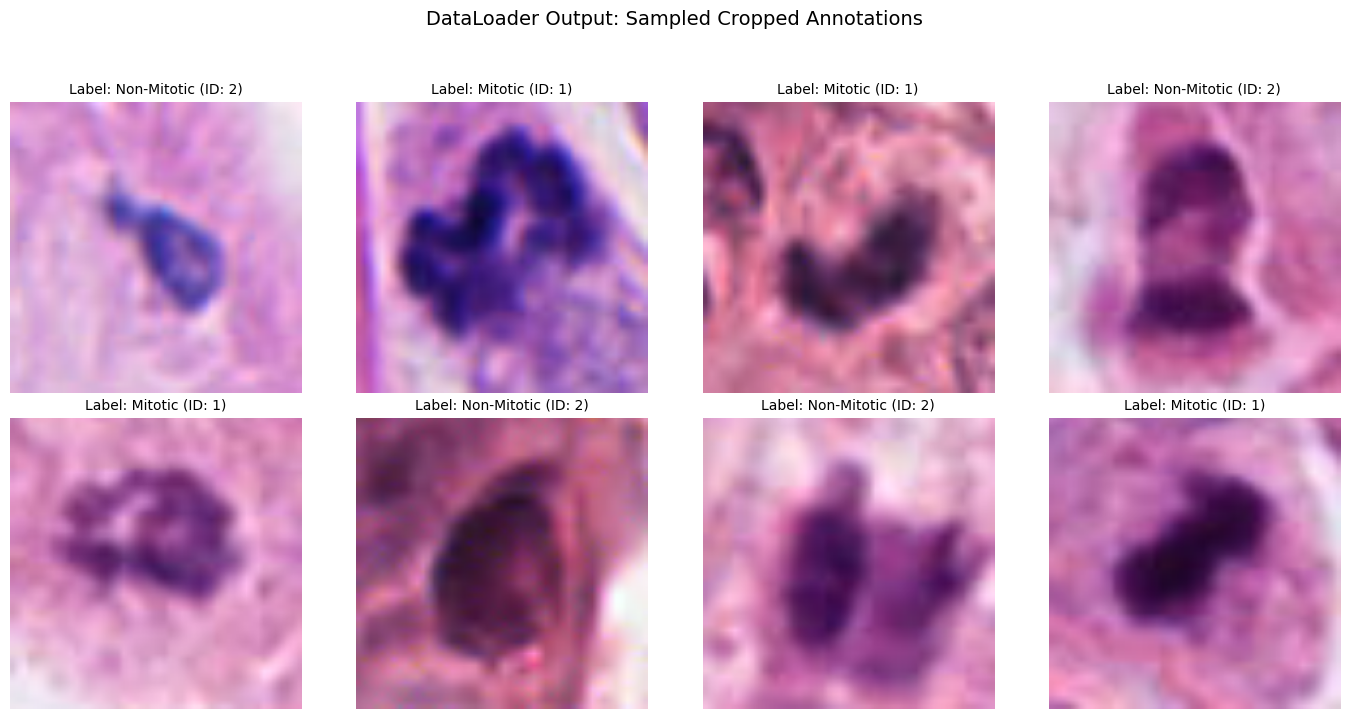

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1. Function to Display a Batch ---

def visualize_dataloader_batch(data_loader, num_images=8, label_mapping={1: 'Mitotic', 2: 'Non-Mitotic'}):
    """
    Samples a batch from the DataLoader, converts the images back to a displayable
    format, and plots them in a grid.
    
    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader object.
        num_images (int): The maximum number of images to display from the batch.
        label_mapping (dict): A dictionary to map numeric labels (1, 2) to names.
    """
    print("Sampling and visualizing a batch from the DataLoader...")
    
    # Get one batch of data
    try:
        batch = next(iter(data_loader))
    except StopIteration:
        print("Error: DataLoader is empty.")
        return

    images = batch['image']
    labels = batch['label']
    
    # Calculate the grid size
    display_count = min(num_images, images.shape[0])
    cols = 4  # Fixed number of columns for a nice grid
    rows = (display_count + cols - 1) // cols
    
    plt.figure(figsize=(3.5 * cols, 3.5 * rows))
    plt.suptitle("DataLoader Output: Sampled Cropped Annotations", fontsize=14, y=1.02)
    
    for i in range(display_count):
        ax = plt.subplot(rows, cols, i + 1)
        
        # 1. Reverse the PyTorch transformation (Tensor to Numpy)
        image = images[i].cpu().numpy()
        
        # 2. Transpose the image from (C, H, W) to (H, W, C) for Matplotlib
        image = np.transpose(image, (1, 2, 0))
        
        # 3. Clip values to the valid range [0, 1] after conversion
        image = np.clip(image, 0, 1)

        # 4. Get the human-readable label
        label_id = labels[i].item()
        label_text = label_mapping.get(label_id, f"Label {label_id}")
        
        # Display the image and title
        ax.imshow(image)
        ax.set_title(f"Label: {label_text} (ID: {label_id})", fontsize=10)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for suptitle
    plt.show()

# --- 2. Execute Visualization ---

# Run the visualization function using your active data_loader
visualize_dataloader_batch(data_loader, num_images=8)

Base CNN

In [ ]:
import torch